# BERT models

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch
from utils.text_datasets import get_basic_tweet_sentiment_dataset, get_poem_sentiment_dataset, get_advanced_tweet_sentiment_dataset_only_text
import tqdm
from sklearn.model_selection import train_test_split
from utils.metrics import get_metrics, display_clasification_metrics

/home/bartek/mimi/NLP-2025-main/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
params = {"train_size":0.9,
"bert_unfrozen_layers":6,
"batch_size":64,
"epochs":3,
"learning_rate":2e-5,
"class_num":5,
"max_length_token":128,
"model_bert":"bert-base-uncased"}

In [4]:
tokenizer = BertTokenizer.from_pretrained(params["model_bert"])

In [5]:
def tokenize_function_bert(text):
    encoding = tokenizer(
        text,
        padding=False,
        truncation=True,
        max_length=params["max_length_token"],
        return_tensors=None
    )
    return torch.tensor(encoding["input_ids"])


def pad_collate_bert(batch):
    input_ids, labels = zip(*batch)
    attention_masks = []

    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    for ids in input_ids:
        mask = torch.ones(len(ids), dtype=torch.long)
        attention_masks.append(mask)
    padded_attention_mask = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    
    return {
        "input_ids": padded_input_ids,
        "attention_mask": padded_attention_mask,
        "labels": torch.tensor(labels)
    }

In [6]:
# train_dataset, validation_dataset, test_dataset = get_poem_sentiment_dataset(tokenize_function_bert)

In [7]:
train_dataset, test_dataset = get_basic_tweet_sentiment_dataset(tokenize_function_bert)
train_dataset, validation_dataset = train_test_split(
    train_dataset, train_size=params["train_size"], shuffle=True
)

/home/bartek/mimi/NLP-2025-main/utils/text_datasets.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.tokinizer(self.text[idx])), torch.tensor(


In [8]:
# train_dataset, test_dataset = get_advanced_tweet_sentiment_dataset_only_text(tokenize_function_bert)
# train_dataset, validation_dataset = train_test_split(
#     train_dataset, train_size=params["train_size"], shuffle=True
# )

In [9]:
class_num = params["class_num"]
dataset_labels = list(range(class_num))
dataset_labels = [0, 2, 4]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, collate_fn=pad_collate_bert)
validation_loader = DataLoader(validation_dataset, batch_size=params["batch_size"], shuffle=False, collate_fn=pad_collate_bert)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False, collate_fn=pad_collate_bert)

In [11]:
def freeze_bert_layers(model, num_unfrozen_layers):
    total_layers = len(model.bert.encoder.layer)
    for i, layer in enumerate(model.bert.encoder.layer):
        if i < total_layers - num_unfrozen_layers:
            for param in layer.parameters():
                param.requires_grad = False
    return model

In [12]:
model = BertForSequenceClassification.from_pretrained(params["model_bert"], num_labels=params["class_num"]).to(device)
model = freeze_bert_layers(model, num_unfrozen_layers=params["bert_unfrozen_layers"])

optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
loss_fun = CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.train()
progress_bar = tqdm.tqdm(range(params["epochs"]), desc="Epoch")

for epoch in progress_bar:
    total_loss = 0
    batches = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1

    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_batches = 0
        for batch in validation_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            val_batches += 1

    model.train()
    progress_bar.set_postfix({
        "Train loss": total_loss / batches,
        "Validation loss": val_loss / val_batches
    })

Epoch:  33%|███▎      | 1/3 [45:31<1:31:03, 2731.78s/it, Train loss=0.334, Validation loss=0.305]

In [ ]:
def measure_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

Train set metrics


F1 Score 0.9031939629860561
Accuracy 0.9032375
Recall 0.9032413883864303

Validation set metrics
F1 Score 0.8717576750035797
Accuracy 0.871825
Recall 0.8717898184039178

Test set metrics


/home/bartek/mimi/NLP-2025-main/utils/text_datasets.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.tokinizer(self.text[idx])), torch.tensor(


F1 Score 0.48746056203683324
Accuracy 0.6244979919678715
Recall 0.5774094079178825


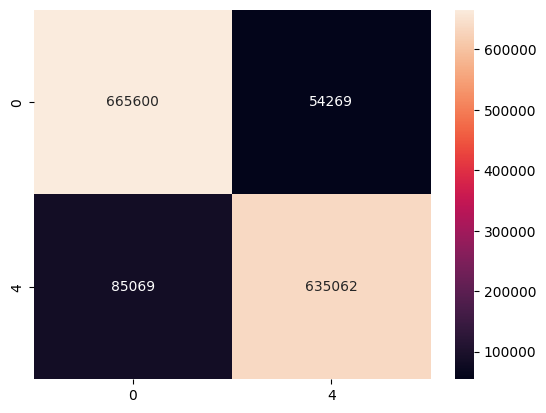

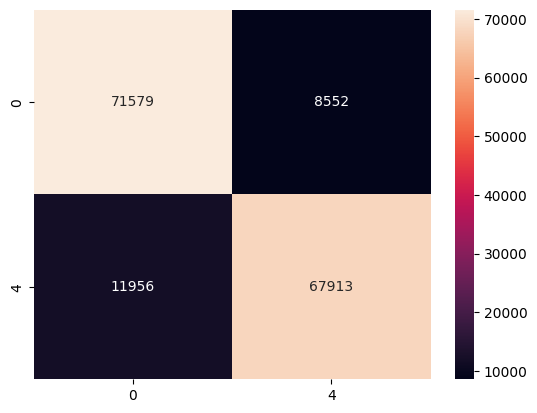

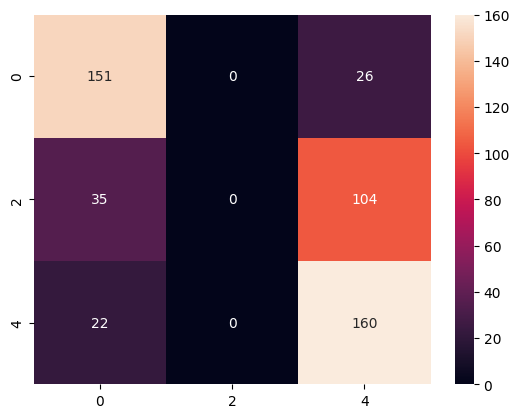

In [ ]:
# print("Train set metrics")
# train_labels, train_preds = measure_model(model, train_loader)
# train_preds_tensor = torch.tensor(train_preds)
# train_labels_tensor = torch.tensor(train_labels)

# display_clasification_metrics(train_preds_tensor, train_labels_tensor, labels=dataset_labels)
# plt.figure()

# print("\nValidation set metrics")
# val_labels, val_preds = measure_model(model, validation_loader)
# val_preds_tensor = torch.tensor(val_preds)
# val_labels_tensor = torch.tensor(val_labels)

# display_clasification_metrics(val_preds_tensor, val_labels_tensor, labels=dataset_labels)
# plt.figure()

print("\nTest set metrics")
test_labels, test_preds = measure_model(model, test_loader)
test_preds_tensor = torch.tensor(test_preds)
test_labels_tensor = torch.tensor(test_labels)

display_clasification_metrics(test_preds_tensor, test_labels_tensor, labels=dataset_labels)